In [1]:
import pandas as pd
import numpy as np
import joblib
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [2]:
pn.options.dpi = 300

In [3]:
cdnow_raw_df = pd.read_csv("CDNOW_master.txt", sep ="\s+", names = ["customer_id", "date","quantity","price"])

In [4]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [5]:
cdnow_df = cdnow_raw_df \
    .assign(date = lambda x:x['date'].astype(str))\
    .assign(date = lambda x: pd.to_datetime(x['date']))\
    .dropna()

In [6]:
cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [7]:
#cohort analysis: looking at customers which joined at a specific time window ie they were in similar marketing scenarios

In [8]:
cdnow_first_purchase_tbl = cdnow_df \
    .sort_values(['customer_id', 'date'])\
    .groupby('customer_id')\
    .first()

In [9]:
cdnow_first_purchase_tbl

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [10]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [11]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

In [39]:
cdnow_df['amount'] = cdnow_df['price']*cdnow_df['quantity']

In [40]:
cdnow_df.head()

,customer_id,date,quantity,price,amount
0,1,1997-01-01,1,11.77,11.77
1,2,1997-01-12,1,12.00,12.00
2,2,1997-01-12,5,77.00,385.00
3,3,1997-01-02,2,20.76,41.52
4,3,1997-03-30,2,20.76,41.52


In [12]:
#visualizing

<AxesSubplot:xlabel='date'>

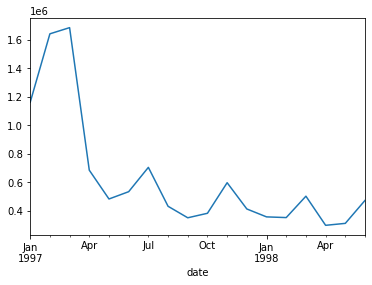

In [43]:
cdnow_df \
    .reset_index() \
    .set_index('date') \
    ['amount'] \
    .resample(
        rule="MS"
    ) \
    .sum() \
    .plot()


In [44]:
#visualise individual customer purchases

In [51]:
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

In [52]:
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [75]:
cdnow_cust_id_subset_df = cdnow_df \
     [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum() \
    .reset_index()

In [76]:
cdnow_cust_id_subset_df

,customer_id,date,quantity,price,amount
0,1,1997-01-01,1,11.77,11.77
1,2,1997-01-12,6,89.00,397.00
2,3,1997-01-02,2,20.76,41.52
3,3,1997-03-30,2,20.76,41.52
4,3,1997-04-02,2,19.54,39.08
5,3,1997-11-15,5,57.45,287.25
6,3,1997-11-25,4,20.96,83.84
7,3,1998-05-28,1,16.99,16.99
8,4,1997-01-01,2,29.33,58.66
9,4,1997-01-18,2,29.73,59.46


C:\Users\Sarthak\anaconda3\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Sarthak\anaconda3\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Sarthak\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\Sarthak\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\Sarthak\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


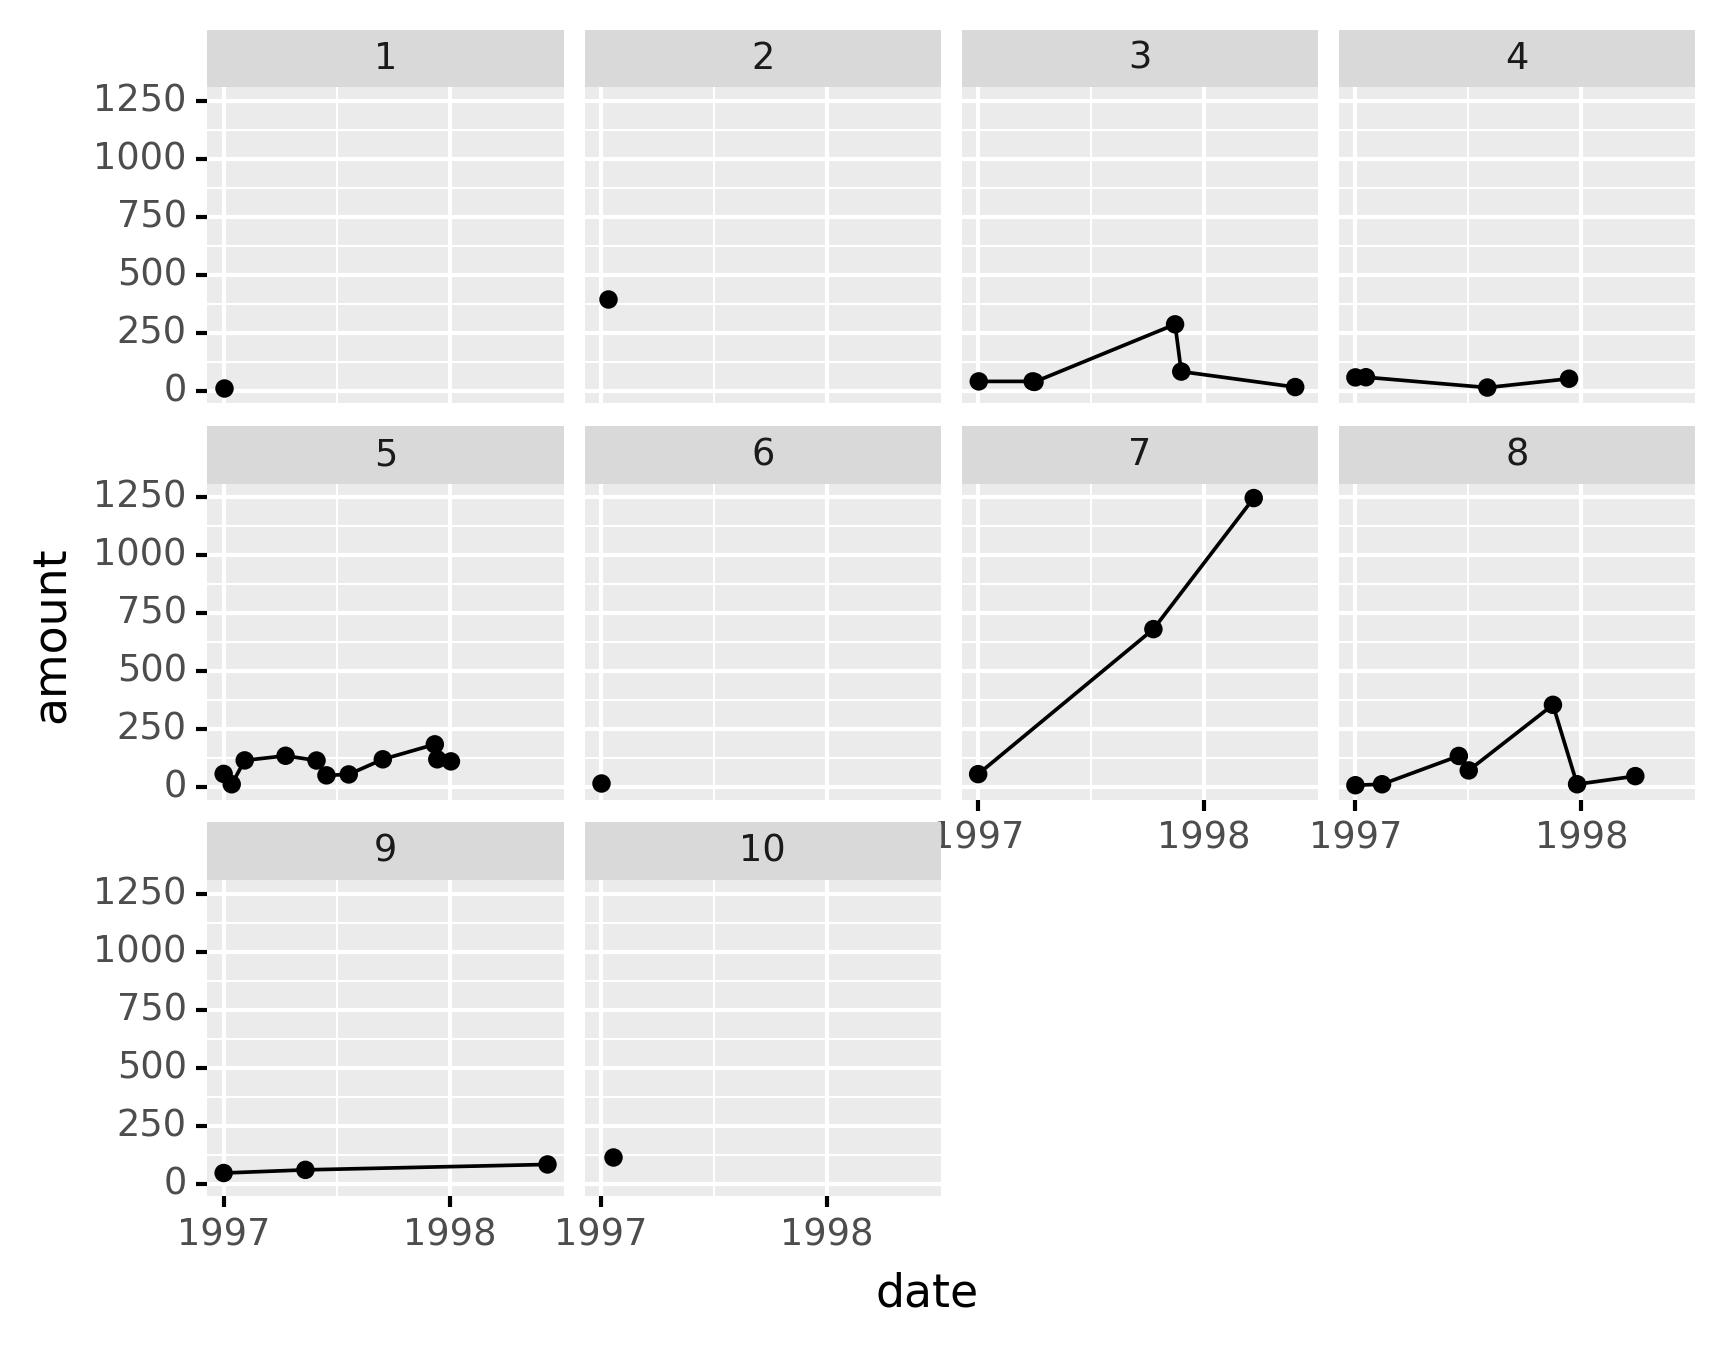

<ggplot: (93958397275)>

In [79]:
pn.ggplot(
    pn.aes('date','amount',group='customer_id'),
    data = cdnow_cust_id_subset_df
) \
    +pn.geom_line() \
    +pn.geom_point() \
    +pn.facet_wrap('customer_id') \
    +pn.scale_x_date(
        date_breaks= "1 year",
        date_labels="%Y"
    )

In [ ]:
#q1 - what will the customers spend in the next 90 days
#q2 - what is the probability of a customer to make a purchase in the next 90 days

In [ ]:
#temporal splitting

In [80]:
n_days = 90
max_date = cdnow_df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit="d")

In [81]:
temporal_in_df = cdnow_df \
    [cdnow_df['date'] <= cutoff]

temporal_out_df = cdnow_df \
    [cdnow_df['date'] > cutoff]

In [ ]:
#feature engineering

In [121]:
#target
targets_df = temporal_out_df \
    .drop("quantity", axis=1) \
    .drop("price", axis=1) \
    .groupby("customer_id") \
    .sum() \
    .rename({"amount":"spend_90_total"}, axis=1) \
    .assign(spend_90_flag = 1) 



In [118]:
targets_df.head()

,customer_id,spend_90_total,spend_90_flag
0,3,16.99,1
1,9,83.96,1
2,25,148.35,1
3,29,193.80,1
4,31,396.86,1


In [ ]:
#feature - recency

In [95]:
max_date = temporal_in_df['date'].max()

In [100]:
recency_features_df = temporal_in_df \
    [['customer_id','date']] \
    .groupby('customer_id') \
    .apply(
        lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, "day")
    ) \
    .to_frame() \
    .set_axis(["recency"], axis=1)

In [101]:
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [102]:
#feature - frequency


In [105]:
frequency_features_df = temporal_in_df \
    [['customer_id','date']] \
    .groupby('customer_id') \
    .count() \
    .set_axis(["frequency"], axis=1)

In [106]:
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [107]:
#feature - monetary


In [110]:
monetary_features_df = temporal_in_df \
    [['customer_id','amount']] \
    .groupby('customer_id') \
    .aggregate(
        {
            'amount': ["sum","mean"]
        }
    ) \
    .set_axis(["amount_sum","amount_mean"], axis=1)

In [111]:
monetary_features_df

,amount_sum,amount_mean
customer_id,,
1,11.77,11.770000
2,397.00,198.500000
3,493.21,98.642000
4,186.04,46.510000
5,1091.74,99.249091
...,...,...
23566,72.00,72.000000
23567,20.97,20.970000
23568,372.92,124.306667


In [112]:
#combine features

In [122]:
features_df = pd.concat([recency_features_df, frequency_features_df, monetary_features_df], axis=1) \
    .merge(
        targets_df,
        left_index= True,
        right_index=True,
        how = "left") \
    .fillna(0)

In [123]:
features_df

,recency,frequency,amount_sum,amount_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,397.00,198.500000,0.00,0.0
3,-127.0,5,493.21,98.642000,16.99,1.0
4,-110.0,4,186.04,46.510000,0.00,0.0
5,-88.0,11,1091.74,99.249091,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,72.00,72.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,372.92,124.306667,0.00,0.0


In [124]:
#machine learning

In [129]:
X = features_df[['recency','frequency','amount_sum','amount_mean']]

#next 90 day spend prediction

y_spend = features_df['spend_90_total']

In [132]:
xgb_reg_spec = XGBRegressor(
    objective = "reg:squarederror",
    random_state=123
)

xgb_reg_model = GridSearchCV(
    estimator = xgb_reg_spec,
    param_grid = dict(learning_rate= [0.01,0.1,0.3,0.5]),
    scoring = "neg_mean_absolute_error",
    refit = True,
    cv = 5
)

In [133]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,


In [134]:
xgb_reg_model.best_score_

-53.239599841589566

In [135]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [136]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [137]:
predictions_reg = xgb_reg_model.predict(X)

In [138]:
predictions_reg

array([ 1.5996397,  5.646012 , 38.968006 , ..., 10.189518 ,  3.5831947,
        5.9208965], dtype=float32)

In [139]:
#next 90 day spend prob

In [140]:
y_prob = features_df['spend_90_flag']

In [141]:
xgb_clf_spec = XGBClassifier(
    objective = "binary:logistic",
    random_state=123
)

xgb_clf_model = GridSearchCV(
    estimator = xgb_clf_spec,
    param_grid = dict(learning_rate=[0.01,0.1,0.3,0.5]),
    scoring = 'roc_auc',
    refit = True,
    cv=5)

In [142]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [143]:
xgb_clf_model.best_score_

0.8355614209974176

In [144]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [145]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [146]:
predictions_clf = xgb_clf_model.predict_proba(X)

In [147]:
predictions_clf

array([[0.79954576, 0.20045425],
       [0.7901529 , 0.20984711],
       [0.63703203, 0.362968  ],
       ...,
       [0.7569424 , 0.2430576 ],
       [0.7954756 , 0.20452441],
       [0.78004754, 0.21995246]], dtype=float32)

In [148]:
#feature importance

In [149]:
#spend amount

In [150]:
imp_spend_amount_dict = xgb_reg_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain')

In [151]:
imp_spend_amount_dict

{'recency': 12108510.0,
 'frequency': 40790544.0,
 'amount_sum': 355997504.0,
 'amount_mean': 1718802.625}

In [154]:
imp_spend_amount_df = pd.DataFrame(
    data = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
)   \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
    )

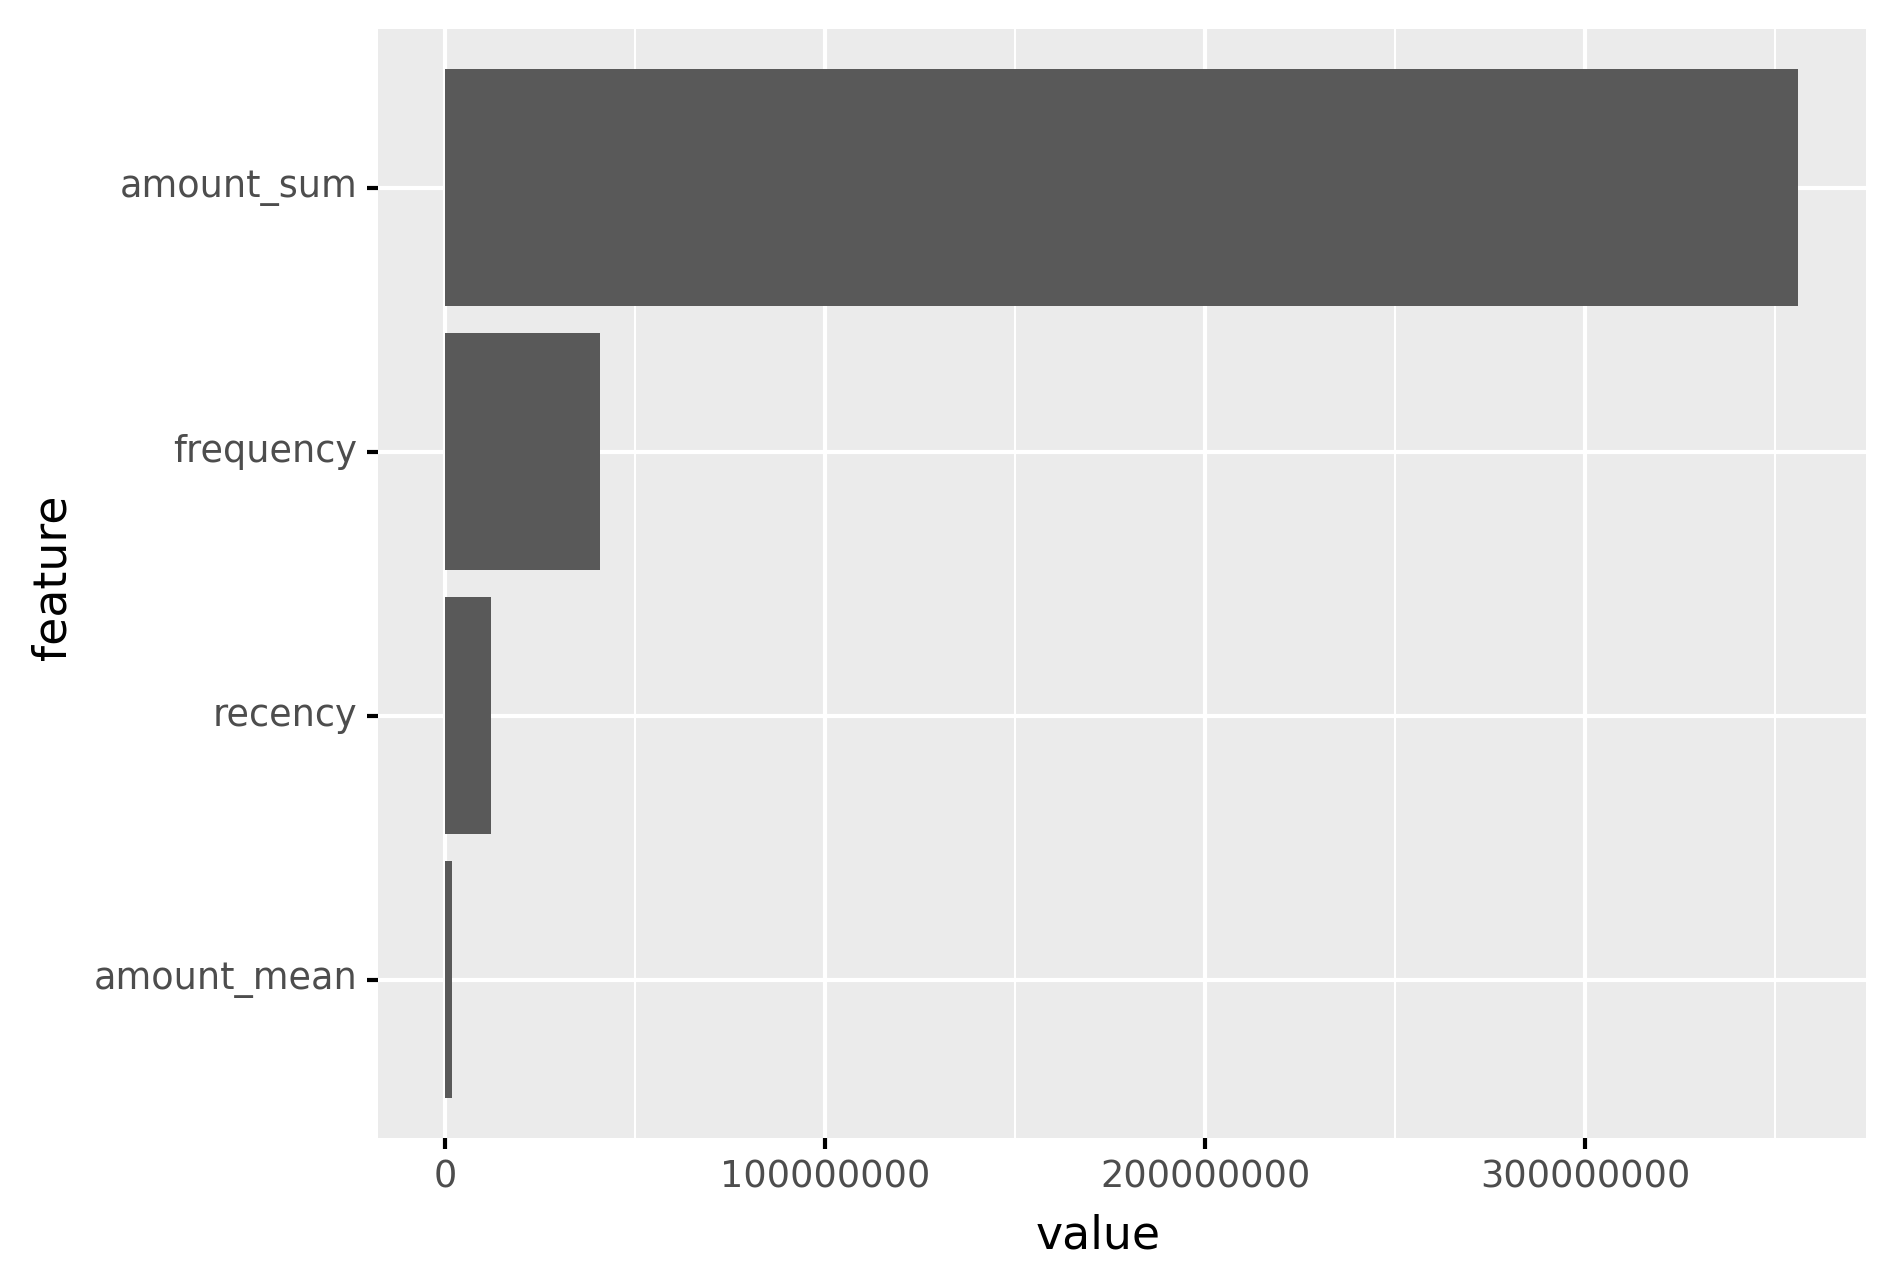

<ggplot: (93958860987)>

In [155]:
pn.ggplot(
    pn.aes('feature', 'value'),
    data = imp_spend_amount_df
) \
    +pn.geom_col() \
    +pn.coord_flip()

In [156]:
#spend prob model

In [157]:
imp_spend_prob_dict = xgb_clf_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain')

In [158]:
imp_spend_prob_df = pd.DataFrame(
    data = {
        'feature':list(imp_spend_prob_dict.keys()),
        'value':list(imp_spend_prob_dict.values())
    }
)   \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
    )

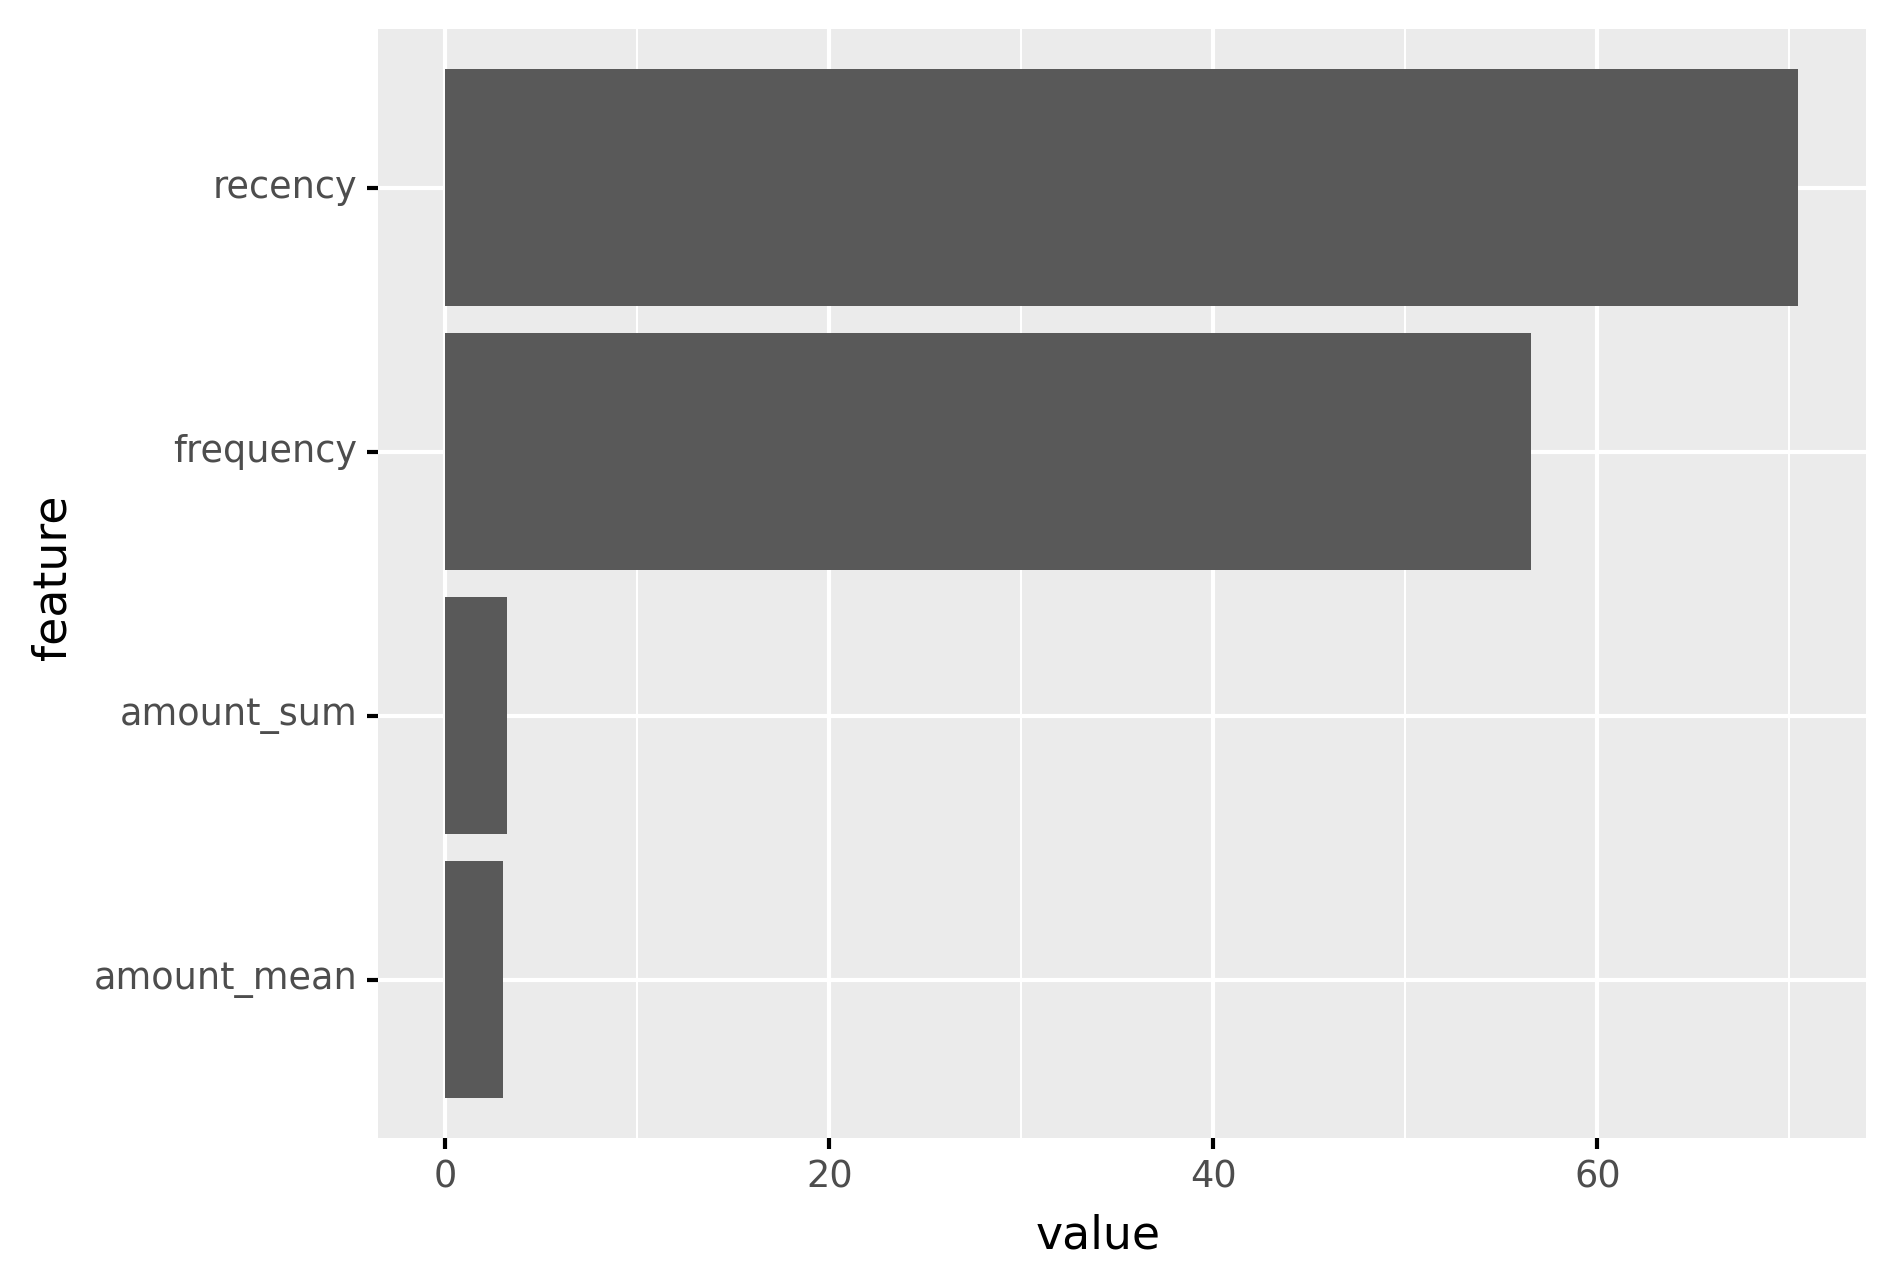

<ggplot: (93958860819)>

In [159]:
pn.ggplot(
    pn.aes('feature', 'value'),
    data = imp_spend_prob_df
) \
    +pn.geom_col() \
    +pn.coord_flip()

In [160]:
#save predictions
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features_df.reset_index()
    ], axis = 1
)

In [162]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,amount_sum,amount_mean,spend_90_total,spend_90_flag
0,1.599640,0.200454,1,-455.0,1,11.77,11.770000,0.00,0.0
1,5.646012,0.209847,2,-444.0,2,397.00,198.500000,0.00,0.0
2,38.968006,0.362968,3,-127.0,5,493.21,98.642000,16.99,1.0
3,12.116765,0.340732,4,-110.0,4,186.04,46.510000,0.00,0.0
4,58.438602,0.550284,5,-88.0,11,1091.74,99.249091,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,3.785190,0.204524,23566,-372.0,1,72.00,72.000000,0.00,0.0
23566,2.106834,0.204524,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,10.189518,0.243058,23568,-344.0,3,372.92,124.306667,0.00,0.0
23568,3.583195,0.204524,23569,-372.0,1,51.48,51.480000,0.00,0.0


In [164]:
predictions_df.to_pickle("predictions_df.pkl")

In [165]:
imp_spend_amount_df.to_pickle("imp_spend_amount_df.pkl")
imp_spend_prob_df.to_pickle("imp_spend_prob_df.pkl")

In [166]:
joblib.dump(xgb_reg_model, 'xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'xgb_clf_model.pkl')

['xgb_clf_model.pkl']